In [1]:
from typing import Callable

import numpy as np
import matplotlib.gridspec as gs
from ezephys import stimtools as st
from ezephys import pltools
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import plotly.express as px

from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import dash_bootstrap_components as dbc

In [2]:
# experiment wide parameters
dt = 0.1

In [3]:
def DesignExponentialFilter(tau_ms, filter_length_ms):
  t = np.arange(0, filter_length_ms, dt)
  IRF_filter = np.exp(-t / tau_ms)
  IRF_filter = IRF_filter/sum(IRF_filter)
  IRF_filter[0] = 0
  return IRF_filter, t

def get_sigmoid(loc: float, sensitivity: float, gain: float) -> Callable[[np.ndarray], np.ndarray]:
    def sigmoid(x):
        return gain / (1 + np.exp(-(x - loc) / sensitivity))
    return sigmoid

def get_filter(kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  """Get a function that convolves the kernel with an input."""
  return lambda input_: lfilter(kernel, 1, input_, axis=-1, zi=None)

def get_linear_nonlinear_model(
  membrane_kernel: np.ndarray, nonlinear_kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  membrane_filter = get_filter(membrane_kernel)
  sodium_filter = get_filter(nonlinear_kernel)

  def linear_nonlinear_model(dendritic_input: np.ndarray, loc: float, sensit: float, gain: float) -> [np.ndarray, np.ndarray]:
    assert np.ndim(dendritic_input) == 1
    sigmoid = get_sigmoid(loc, sensit, gain)

    return [sigmoid(sodium_filter(dendritic_input)) + membrane_filter(dendritic_input), membrane_filter(dendritic_input)]
    
  return linear_nonlinear_model

In [4]:
def delayed_pulse(delay_ms: float, peak_amplitude: float, total_duration: float = 600.) -> st.ConvolvedStimulus:
    """Create ConvolvedStimulus containing a synaptic pulse with a delayed start."""
    synaptic_kernel = st.BiexponentialSynapticKernel(peak_amplitude, 0.1, 5, duration=25., dt=dt)

    pulse_time = np.zeros(int(total_duration / dt - 0.5))
    pulse_time[int(delay_ms / dt - 0.5)] = 1.
    pulse = st.ConvolvedStimulus(0, synaptic_kernel)
    pulse.generate(pulse_time, dt)
    return pulse, pulse_time

In [5]:
# na kernel
na_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=5, filter_length_ms=100)
na_nl_kernel, _ = DesignExponentialFilter(tau_ms=5, filter_length_ms=100)

na_kernel = get_linear_nonlinear_model(na_membrane_kernel, na_nl_kernel)

# ca kernel
ca_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=40, filter_length_ms=100)
ca_nl_kernel, _ = DesignExponentialFilter(tau_ms=40, filter_length_ms=200)

ca_kernel = get_linear_nonlinear_model(ca_membrane_kernel, ca_nl_kernel)

# nmda kernel
nmda_membrane_kernel, _ = DesignExponentialFilter(
    tau_ms=80, filter_length_ms=200)
nmda_nl_kernel, _ = DesignExponentialFilter(tau_ms=80, filter_length_ms=200)

nmda_kernel = get_linear_nonlinear_model(nmda_membrane_kernel, nmda_nl_kernel)

In [6]:
def compute_blocker_graph(na_loc, na_sensit, na_gain, ca_loc, ca_sensit, ca_gain, nmda_loc, nmda_sensit, nmda_gain):
    # create input intensities to evaluate
    min_intensity = 0
    max_intensity = 15

    intensities = np.arange(min_intensity, max_intensity, 0.4)
    peaks_control = np.zeros(len(intensities))
    peaks_blocked = np.zeros(len(intensities))

    # calculate peak amplitudes for non blocked Ca and Na channels
    for e, intensity in enumerate(intensities):
        input_epsp, _ = delayed_pulse(
            delay_ms=20, peak_amplitude=intensity)
        input_epsp = input_epsp.command.flatten()
        y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, ca_gain)
        y_na, _= na_kernel(input_epsp, na_loc, na_sensit, na_gain)
        y_nmda_sum, _ = nmda_kernel(
            y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)
        peak = np.max(y_nmda_sum)
        peaks_control[e] = peak


        # calculate peak amplitudes for blocked Ca and Na channels (set sigmoid gain to 0)
        for e, intensity in enumerate(intensities):
            input_epsp, _ = delayed_pulse(
                delay_ms=20, peak_amplitude=intensity)
            input_epsp = input_epsp.command.flatten()
            y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, 0)
            y_na, _= na_kernel(input_epsp, na_loc, na_sensit, 0)
            y_nmda_sum, _ = nmda_kernel(
                y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)
            peak = np.max(y_nmda_sum)
            peaks_blocked[e] = peak

    return [intensities, peaks_control, peaks_blocked]

def compute_traces_for_specific_input(peak, na_loc, na_sensit, na_gain, ca_loc, ca_sensit, ca_gain, nmda_loc, nmda_sensit, nmda_gain):
    input_epsp, _ = delayed_pulse(
        delay_ms=20, peak_amplitude=peak)
    input_epsp = input_epsp.command.flatten()
    y_ca_control, _= ca_kernel(input_epsp, ca_loc, ca_sensit, ca_gain)
    y_na_control, _= na_kernel(input_epsp, na_loc, na_sensit, na_gain)
    y_nmda_sum_control, _ = nmda_kernel(
        y_ca_control+y_na_control, nmda_loc, nmda_sensit, nmda_gain)

# calculate peak amplitudes for blocked Ca and Na channels (set sigmoid gain to 0)
    input_epsp, t = delayed_pulse(
        delay_ms=20, peak_amplitude=peak)
    input_epsp = input_epsp.command.flatten()
    y_ca, _= ca_kernel(input_epsp, ca_loc, ca_sensit, 0)
    y_na, _= na_kernel(input_epsp, na_loc, na_sensit, 0)
    y_nmda_sum, _ = nmda_kernel(
        y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)

    return {'input': input_epsp, 'ca_control': y_ca_control, 'na_control': y_na_control, 'nmda_control': y_nmda_sum_control, 'ca_blocked': y_ca, 'na_blocked': y_na, 'nmda_blocked': y_nmda_sum, 'time': t}

In [7]:
intensities, peaks_control, peaks_blocked = compute_blocker_graph(1.2, 0.14, 2.1, 0.6, 0.16, 1, 0.8, 0.1, 6)
peaks_blocked

array([2.01210078e-03, 3.73774384e-02, 7.30845858e-02, 1.09274149e-01,
       1.46144348e-01, 1.83974400e-01, 2.23157166e-01, 2.64244529e-01,
       3.08009992e-01, 3.55534207e-01, 4.08320070e-01, 4.68444250e-01,
       5.38749986e-01, 6.23079346e-01, 7.26527375e-01, 8.55669312e-01,
       1.01865816e+00, 1.22501166e+00, 1.48482436e+00, 1.80711765e+00,
       2.19720681e+00, 2.65345813e+00, 3.16458331e+00, 3.70917872e+00,
       4.25874859e+00, 4.78368405e+00, 5.25973920e+00, 5.67219345e+00,
       6.01646382e+00, 6.29594355e+00, 6.51877007e+00, 6.69491583e+00,
       6.83421188e+00, 6.94530551e+00, 7.03529059e+00, 7.10972739e+00,
       7.17284182e+00, 7.22777828e+00])

In [8]:
input_amp = 7
data = compute_traces_for_specific_input(input_amp, 1.2, 0.14, 2.1, 0.6, 0.16, 1, 0.8, 0.1, 6)

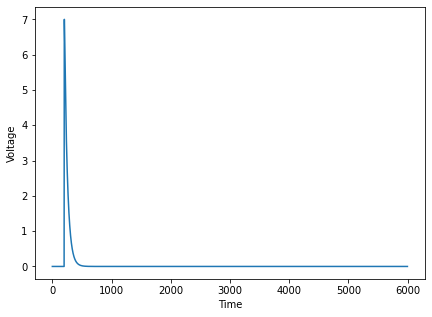

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(data['input'])
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.savefig('./figures/nmda_input_amp7.svg')
plt.show()

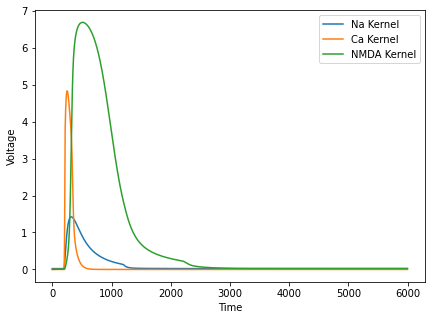

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(data['ca_control'], label='Na Kernel')
plt.plot(data['na_control'], label='Ca Kernel')
plt.plot(data['nmda_control'], label='NMDA Kernel')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.savefig('./figures/nmda_control_amp7.svg')
plt.show()

In [13]:
time = np.arange(0, len(data['input'])) / 100

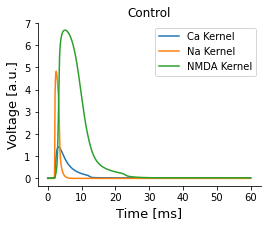

In [20]:
plt.figure(figsize=(4, 3))

ax = plt.subplot(111)
ax.plot(time, data['ca_control'], label='Ca Kernel')
ax.plot(time, data['na_control'], label='Na Kernel')
ax.plot(time, data['nmda_control'], label='NMDA Kernel')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Time [ms]', fontsize=13)
ax.set_ylabel('Voltage [a.u.]', fontsize=13)
ax.set_title('Control')
ax.legend()

plt.savefig('./figures/nmda_control_amp7.svg', bbox_inches = "tight")
plt.show()
controlYlim = ax.get_ylim()

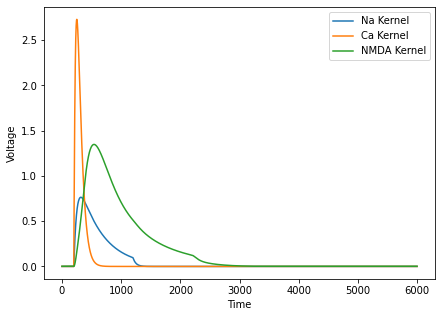

In [15]:
plt.figure(figsize=(7, 5))
plt.plot(data['ca_blocked'], label='Na Kernel')
plt.plot(data['na_blocked'], label='Ca Kernel')
plt.plot(data['nmda_blocked'], label='NMDA Kernel')

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.savefig('./figures/nmda_blocked_amp7.svg')
plt.show()

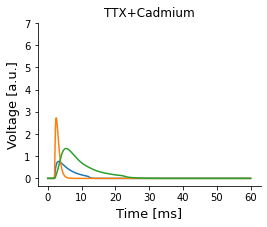

In [19]:
plt.figure(figsize=(4, 3))

ax = plt.subplot(111)
ax.plot(time, data['ca_blocked'], label='Ca Kernel')
ax.plot(time, data['na_blocked'], label='Na Kernel')
ax.plot(time, data['nmda_blocked'], label='NMDA Kernel')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Time [ms]', fontsize=13)
ax.set_ylabel('Voltage [a.u.]', fontsize=13)
ax.set_ylim(controlYlim)
ax.set_title('TTX+Cadmium')
plt.savefig('./figures/nmda_blocked_amp7.svg', bbox_inches = "tight")
plt.show()

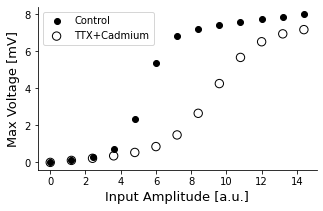

In [31]:
plt.figure(figsize=(5, 3))

ax = plt.subplot(111)
ax.scatter(intensities[::3], peaks_control[::3], marker='o', c='black', label='Control')
ax.scatter(intensities[::3], peaks_blocked[::3], facecolors='none', edgecolors='black', s=70, label='TTX+Cadmium')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Input Amplitude [a.u.]', fontsize=13)
ax.set_ylabel('Max Voltage [mV]', fontsize=13)
ax.legend()

plt.savefig('./figures/nmda_control.svg', bbox_inches = "tight")
plt.show()

In [31]:
intensities[::2]

array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
        8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4])

In [33]:
# na kernel
na_membrane_kernel, _ = DesignExponentialFilter(tau_ms=10, filter_length_ms=100)
na_nl_kernel, _ = DesignExponentialFilter(tau_ms=5, filter_length_ms=100)

na_kernel = get_linear_nonlinear_model(na_membrane_kernel, na_nl_kernel)

In [34]:
# ca kernel
ca_membrane_kernel, _ = DesignExponentialFilter(tau_ms=50, filter_length_ms=100)
ca_nl_kernel, _ = DesignExponentialFilter(tau_ms=40, filter_length_ms=100)

ca_sigmoid = get_sigmoid(ca_loc, ca_sensit, ca_gain)
ca_kernel = get_linear_nonlinear_model(ca_membrane_kernel, ca_nl_kernel)

In [35]:
# nmda kernel
nmda_membrane_kernel, _ = DesignExponentialFilter(tau_ms=100, filter_length_ms=200)
nmda_nl_kernel, _ = DesignExponentialFilter(tau_ms=100, filter_length_ms=200)

nmda_kernel = get_linear_nonlinear_model(nmda_membrane_kernel, nmda_nl_kernel)

In [36]:
input_epsp = delayed_pulse(delay_ms=20, peak_amplitude=10)

In [71]:
input_signal_pane = dbc.Card(
    dbc.CardBody(
        [
        dcc.Graph(id='input_graph'),
        html.Label([
        'Peak',
        dcc.Slider(
            id='input-peak-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        ]
    )
)
na_pane = dbc.Card(
    dbc.CardBody(
        [
        dcc.Graph(id='na_graph'),
        html.Label([
        'Loc',
        dcc.Slider(
            id='na-loc-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        html.Label([
        'Sensit',
        dcc.Slider(
            id='na-sensit-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        html.Label([
        'Gain',
        dcc.Slider(
            id='na-gain-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        ]
    )
)
ca_pane = dbc.Card(
    dbc.CardBody(
        [
        dcc.Graph(id='ca_graph'),
        html.Label([
        'Loc',
        dcc.Slider(
            id='ca-loc-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        html.Label([
        'Sensit',
        dcc.Slider(
            id='ca-sensit-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        html.Label([
        'Gain',
        dcc.Slider(
            id='ca-gain-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ]),
        ]
    )
)
nmda_pane = html.Div([
    dbc.Row(
        dcc.Graph(id='nmda_graph')
    ),
    dbc.Row(
         html.Label([
        'Loc',
        dcc.Slider(
            id='nmda-loc-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ])
    ),
    dbc.Row(
        html.Label([
        'Sensit',
        dcc.Slider(
            id='nmda-sensit-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ])

    ),
    dbc.Row(
   html.Label([
        'Gain',
        dcc.Slider(
            id='nmda-gain-slider',
            min=1,
            max=4,
            step=0.1,
            value=1,
            updatemode='drag',
            tooltip=dict(placement='topLeft')
        )
        ])
        ,
    ]
    )

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 139 (<ipython-input-71-576f8b14ad0e>, line 153)

In [69]:
# Build App
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([
    html.H1("NMDA Spikes analysis"),
    dbc.Container([
        dbc.Row([
            dbc.Col([input_signal_pane]), dbc.Col([na_pane])
        ]),
        dbc.Row([
            dbc.Col([ca_pane]), dbc.Col([nmda_pane])
        ])
    ])
])

# Define callback to update graph
@app.callback(
    Output('input_graph', 'figure'),
    [
        Input('input-peak-slider', 'value'),
    ]
)
def update_input_figure(peak):
    layout = go.Layout(
        title='EPSP Input',
        yaxis=dict(
            title='V'
        ),
        xaxis=dict(
            title='t(ms)'
        )
    )

    input_epsp = delayed_pulse(delay_ms=20, peak_amplitude=peak).command.flatten()
    trace = go.Scatter(
        y=input_epsp,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin+NL'
    )
    fig = go.Figure(data=[trace], layout=layout)
    return fig

# Define callback to update graph
@app.callback(
    Output('na_graph', 'figure'),
    [
        Input('input-peak-slider', 'value'),
        Input('na-loc-slider', 'value'),
        Input('na-sensit-slider', 'value'),
        Input('na-gain-slider', 'value'),
    ]
)
def update_na_figure(peak, loc, sensit, gain):
    layout = go.Layout(
        title='Na kernel',
        yaxis=dict(
            title='voltage'
        ),
        xaxis=dict(
            title='time(ms)'
        )
    )

    input_epsp = delayed_pulse(delay_ms=20, peak_amplitude=peak).command.flatten()
    y_sum, y_lin = na_kernel(input_epsp, loc, sensit, gain)

    trace_sum = go.Scatter(
        y=y_sum,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin+NL'
    )
    trace_lin = go.Scatter(
        y=y_lin,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin'
    )
    fig = go.Figure(data=[trace_sum, trace_lin], layout=layout)
    return fig

# Define callback to update graph
@app.callback(
    Output('ca_graph', 'figure'),
    [
        Input('input-peak-slider', 'value'),
        Input('ca-loc-slider', 'value'),
        Input('ca-sensit-slider', 'value'),
        Input('ca-gain-slider', 'value'),
    ]
)
def update_ca_figure(peak, loc, sensit, gain):
    layout = go.Layout(
        title='Ca kernel',
        yaxis=dict(
            title='voltage'
        ),
        xaxis=dict(
            title='time(ms)'
        )
    )

    input_epsp = delayed_pulse(delay_ms=20, peak_amplitude=peak).command.flatten()
    y_sum, y_lin = ca_kernel(input_epsp, loc, sensit, gain)

    trace_sum = go.Scatter(
        y=y_sum,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin+NL'
    )
    trace_lin = go.Scatter(
        y=y_lin,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin'
    )
    fig = go.Figure(data=[trace_sum, trace_lin], layout=layout)
    return fig

# Define callback to update graph
@app.callback(
    Output('nmda_graph', 'figure'),
    [
        Input('input-peak-slider', 'value'),
        Input('na-loc-slider', 'value'),
        Input('na-sensit-slider', 'value'),
        Input('na-gain-slider', 'value'),
        Input('ca-loc-slider', 'value'),
        Input('ca-sensit-slider', 'value'),
        Input('ca-gain-slider', 'value'),
        Input('nmda-loc-slider', 'value'),
        Input('nmda-sensit-slider', 'value'),
        Input('nmda-gain-slider', 'value'),
    ]
)
def update_nmda_figure(peak, na_loc, na_sensit, na_gain, ca_loc, ca_sensit, ca_gain, nmda_loc, nmda_sensit, nmda_gain):
    layout = go.Layout(
        title='NMDA kernel',
        yaxis=dict(
            title='voltage'
        ),
        xaxis=dict(
            title='time(ms)'
        )
    )
    
    input_epsp = delayed_pulse(delay_ms=20, peak_amplitude=peak).command.flatten()
    y_ca, _ = ca_kernel(input_epsp, ca_loc, ca_sensit, ca_gain)
    y_na, _ = na_kernel(input_epsp, na_loc, na_sensit, na_gain)
    y_nmda_sum, y_nmda_lin = nmda_kernel(y_ca+y_na, nmda_loc, nmda_sensit, nmda_gain)

    trace_sum = go.Scatter(
        y=y_nmda_sum,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin+NL'
    )
    trace_lin = go.Scatter(
        y=y_nmda_lin,
        mode='lines',
        line=dict(
            shape='spline'
        ),
        name='Lin'
    )
    fig = go.Figure(data=[trace_sum, trace_lin], layout=layout)
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/
